In [4]:
import sklearn #software machine learning library for the Python programming language.
from sklearn import model_selection 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,KFold, train_test_split
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

In [5]:
# load the csv file as a data frame
df = pd.read_csv('/Users/grace/Desktop/Courses/Master_thesis/Datsets/redwinequality.csv')


In [6]:
# Making binary classificaion for the response variable.
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

bins = (2, 5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])
df['quality'].value_counts()


1    855
0    744
Name: quality, dtype: int64

In [7]:
df = df.reset_index(drop=True)  # Reset the indices for X and y
# Separate the target variable
X = df.drop('quality', axis=1) #represent the input features
y = df['quality']  #represent the target variable 

#The train_test_split function takes as input the input features X and target variable y, and returns four arrays
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [8]:
# Initialize the Random Forest Classifier
cls = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)

In [9]:
from sklearn.metrics import accuracy_score

# Make predictions on the training and test data
y_train_pred = cls.predict(X_train)
y_train_prob = cls.predict_proba(X_train)[:, 1]
y_test_pred = cls.predict(X_test)
y_test_prob = cls.predict_proba(X_test)[:, 1]

# Calculate the accuracy of the predictions to test the ability of a machine learning model to predict new data
#accuracy_score metric works by dividing the number of correct predictions by the total number of predictions
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the train and test accuracy
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Train accuracy: 0.9916579770594369
Test accuracy: 0.796875


In [10]:
# Evaluate the performance of the original model on the validation set

# .score: This method internally uses the best hyperparameters found during the grid search (grid_search.best_params_) to train a new model on the training set 
# and computes the accuracy of this model on the validation set 
accuracy = cls.score(X_val, y_val)
print(f'Validation accuracy: {accuracy:.4f}')

Validation accuracy: 0.8031


#Confusion matrix

We use the Confusion matrix and HEAT_MAP to summarize the performance of the model and see where it fails with its predictions.

We have 7 False Negative instances that are predicted as 0 class while they are from class 1 in reality.

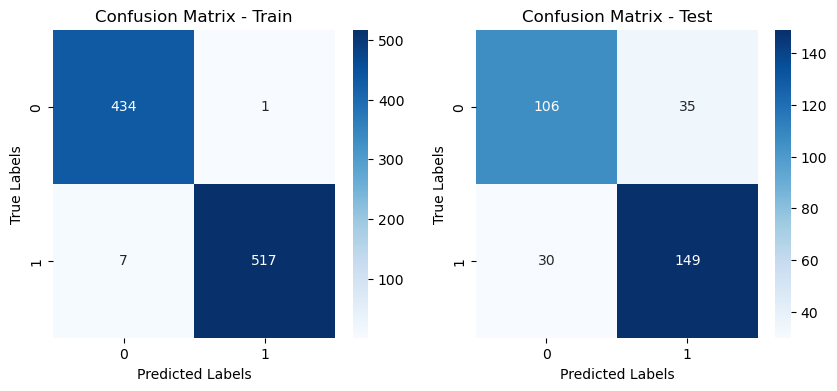

In [15]:
# Plot the confusion matrix as a heatmap, the values in each cell of the heatmap represent the number of test instances
#that belong to the corresponding true values and predicted classes


import matplotlib.pyplot as plt
import seaborn as sns ## we need a heatmap from the seaborn library to visualize the confusion_matrix
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix for the train and test data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.heatmap(cm_train, ax=ax[0], annot=True, cmap='Blues', fmt='d') #The annot=True parameter adds the values to each cell 
sns.heatmap(cm_test, ax=ax[1], annot=True, cmap='Blues', fmt='d')  #fmt='d' sets the format of the values displayed on the heatmap('d' stands for 'decimal'). 

#ax[0] corresponds to the first subplot and ax[1] corresponds to the second subplot
ax[0].set_title('Confusion Matrix - Train')
ax[1].set_title('Confusion Matrix - Test')
ax[0].set_xlabel('Predicted Labels')
ax[1].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[1].set_ylabel('True Labels')
plt.show()

alcohol                 0.199566
sulphates               0.135671
volatile acidity        0.115495
total sulfur dioxide    0.104436
density                 0.091823
chlorides               0.067517
fixed acidity           0.067373
pH                      0.059469
free sulfur dioxide     0.054651
citric acid             0.053480
residual sugar          0.050519
dtype: float64


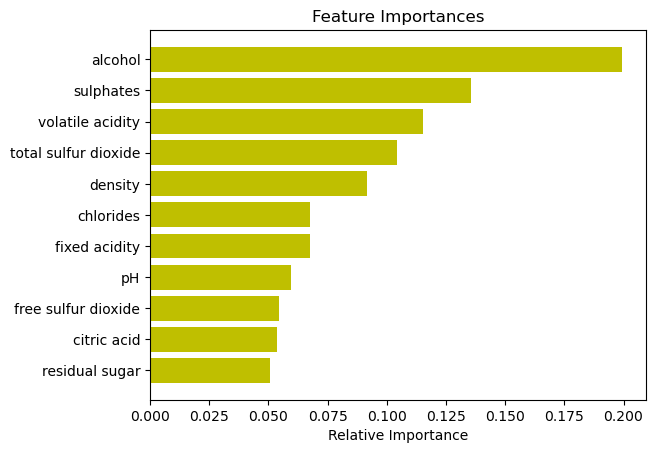

In [11]:
# By default, the impurity measure used for evaluating the quality of the splits in each decision tree is the Gini impurity
importances = pd.Series(cls.feature_importances_, index=X_train.columns)
# Print feature importance
print(importances.sort_values(ascending=False))

#plot the importances
indices = np.argsort(importances)
features = df.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance') 
plt.show()

Train a new model on the top 10 feature called cls_top and test the accuracy of its predictions. 

In [12]:
# Select the top 10 features based on feature importance
top_features = importances.sort_values(ascending=False)[:10].index

# Create a new X dataframe with only the top 10 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Train a new model using only the top 10 features
cls_top = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
cls_top.fit(X_train_top, y_train)

# Make predictions on the test set using the new model
y_test_pred_top = cls_top.predict(X_test_top)
y_train_pred_top = cls_top.predict(X_train_top)

# Evaluate the performance of the new model
test_accuracy_top = accuracy_score(y_test, y_test_pred_top)
train_accuracy_top = accuracy_score(y_train, y_train_pred_top)
print('Train accuracy with top 10 features:', train_accuracy_top)
print('Test accuracy with top 10 features:', test_accuracy_top)



Train accuracy with top 10 features: 0.8310740354535975
Test accuracy with top 10 features: 0.728125


In [24]:
# Hyperparameter Tuning
#GridSearchCV tries all the combinations of the values passed in the dictionary and evaluates the model for each combination using the Cross-Validation method. 
#Hence after using this function we get accuracy/loss for every combination of hyperparameters and we can choose the one with the best performance.

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [2, 4, 5, 6, 8, 10, 15],
    'n_estimators': [10, 50, 100, 150, 200]
}
# Create a Random Forest Classifier object
rfc = RandomForestClassifier(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5) # cv is set to 5 to perform a 5-fold cross-validation during the search.
# Train the GridSearchCV object on the training data
grid_search.fit(X_train_top, y_train)
# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 6, 'n_estimators': 100}


Train a new model on the Hyperparameter Tuning result called grid_search and test the accuracy of its predictions. 

In [25]:
# Make predictions on the test set using the new model
y_test_pred_hyp = grid_search.predict(X_test_top)
y_train_pred_hyp = grid_search.predict(X_train_top)

# Evaluate the performance of the new model from the Hyperparameter Tuning
test_accuracy_hyp = accuracy_score(y_test, y_test_pred_hyp)
train_accuracy_hyp = accuracy_score(y_train, y_train_pred_hyp)
print('Train accuracy with top 10 features:', train_accuracy_hyp)
print('Test accuracy with top 10 features:', test_accuracy_hyp)

Train accuracy with top 10 features: 0.867570385818561
Test accuracy with top 10 features: 0.759375


Explanation part using SHAP

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance.

The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.

we get a sense of the distribution of the Shapley values per feature. 

The features are ordered according to their importance.

In [31]:
#We can use which RF we wanna use/cls, cls_top, or grid_search.best_params_/ and that's depending on what we want
explainer = shap.TreeExplainer(cls_top) #The TreeExplainer object computes the SHAP values of the features for a specific instance.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


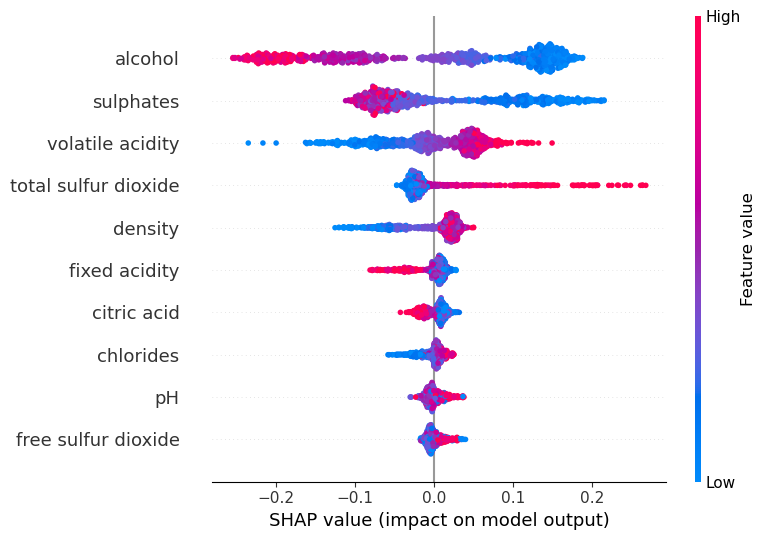

In [34]:
shap_values = explainer.shap_values(X_train_top)

#summary_plot for instances from class 0
shap.summary_plot(shap_values[0], X_train_top.values, feature_names = X_test_top.columns) # We can change the shap_value[1] between 0-5 if we wanna see the features' contribution on other classes
#The x-axis stands for the average of the SHAP value of each feature.

SHAP values measure the contribution of each feature to the difference between the actual model output and the expected model output while considering the presence or absence of the feature. In other words, the SHAP value measures the difference in the model output that can be attributed to the presence or absence of a particular feature, relative to the expected model output.

* The model output refers to the predicted value or probability that the model assigns to a given input instance. 
* The expected model output is the average prediction that the model makes on the training set; It is computed by taking the mean of the output values (i.e., the target variable values) of the training set.

Predicted class label for the instance:  0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


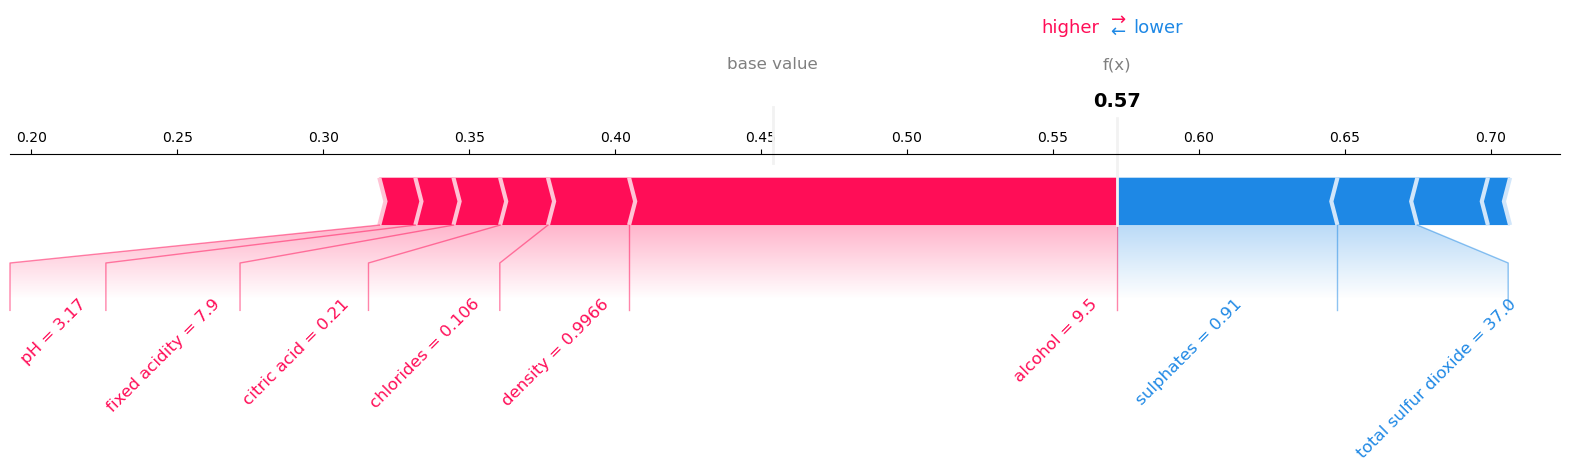

' base_value is the expected or average output of the model over the training dataset. It represents the average model output \nif none of the features were present (i.e., if all features were missing or set to zero). \nThe expected_value attribute in the SHAP explainer object is a vector of length num_classes, where num_classes is the number of classes \nin the model output. \nThe value at index i represents the expected model output for class i. For example, if the model is a binary classifier, \nexpected_value[0] is the expected output value for the negative class, \nand expected_value[1] is the expected output value for the positive class.  '

In [40]:
#Explaining specific instance 
# Select a specific instance from the dataset
instance_to_explain = X_train_top.iloc[9]

# Compute the SHAP values for the selected instance
shap_values = explainer.shap_values(instance_to_explain)

# Predict the class label for the instance
predicted_class = cls_top.predict(instance_to_explain.values.reshape(1, -1))[0]

# Print the predicted class label
print("Predicted class label for the instance: ", predicted_class)

# Plot the SHAP values for the selected instance, The resulting plot shows how each feature contributes to the final output of the model for the selected instance.
shap.initjs() #This initializes the Javascript visualization library for displaying the SHAP plot in the notebook

#specefying the class 0
shap.force_plot(explainer.expected_value[0], shap_values[0], instance_to_explain, matplotlib=True, text_rotation=45, figsize=(20,4))


''' base_value is the expected or average output of the model over the training dataset. It represents the average model output 
if none of the features were present (i.e., if all features were missing or set to zero). 
The expected_value attribute in the SHAP explainer object is a vector of length num_classes, where num_classes is the number of classes 
in the model output. 
The value at index i represents the expected model output for class i. For example, if the model is a binary classifier, 
expected_value[0] is the expected output value for the negative class, 
and expected_value[1] is the expected output value for the positive class.  '''


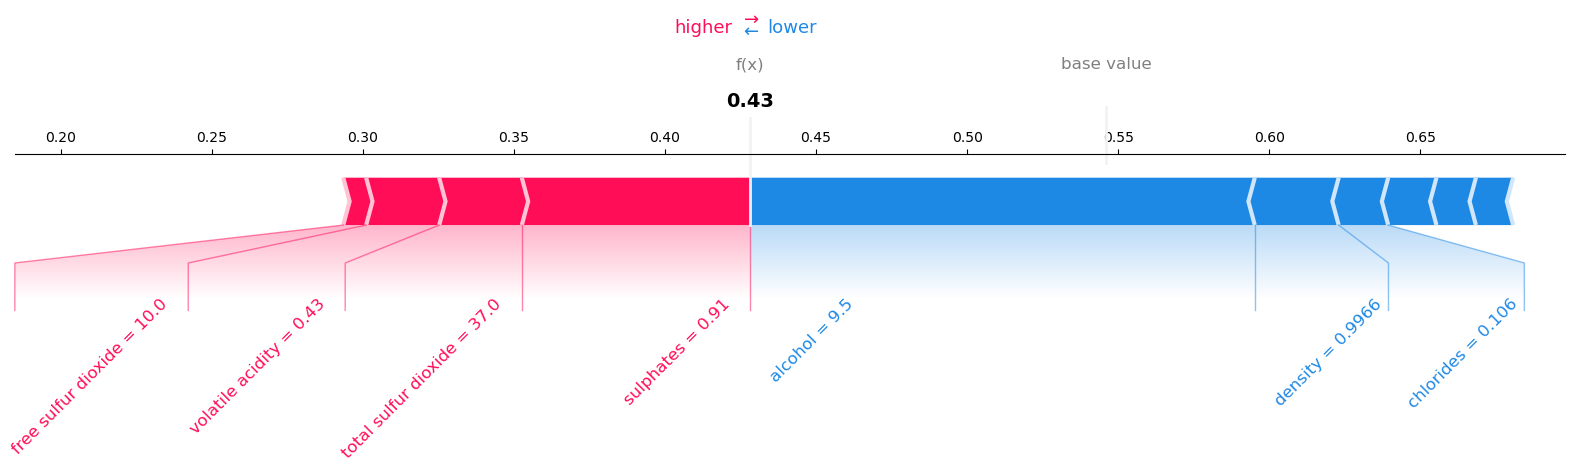

' base_value is the expected or average output of the model over the training dataset. It represents the average model output if none of the features were present (i.e., if all features were missing or set to zero). \nThe expected_value attribute in the SHAP explainer object is a vector of length num_classes, where num_classes is the number of classes in the model output. \nThe value at index i represents the expected model output for class i. For example, if the model is a binary classifier, expected_value[0] is the expected output value for the negative class, \nand expected_value[1] is the expected output value for the positive class.  '

In [41]:
# Plot the SHAP values for the selected instance, The resulting plot shows how each feature contributes to the final output of the model for the selected instance.
shap.initjs() #This initializes the Javascript visualization library for displaying the SHAP plot in the notebook

#specefying the class 1
shap.force_plot(explainer.expected_value[1], shap_values[1], instance_to_explain, matplotlib=True, text_rotation=45, figsize=(20,4))



''' base_value is the expected or average output of the model over the training dataset. It represents the average model output if none of the features were present (i.e., if all features were missing or set to zero). 
The expected_value attribute in the SHAP explainer object is a vector of length num_classes, where num_classes is the number of classes in the model output. 
The value at index i represents the expected model output for class i. For example, if the model is a binary classifier, expected_value[0] is the expected output value for the negative class, 
and expected_value[1] is the expected output value for the positive class.  '''
# the shap_values parameter is the SHAP values of the features on a specific instance.